In [ ]:
# imports
from transformers import AutoTokenizer, AutoModelForMaskedLM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import pickle
from datasets import Dataset
import seaborn as sns
from metrics import contextual_precision, contextual_recall, contextual_relevancy
from sentence_transformers import CrossEncoder

In [2]:
# !pip install faiss-cpu
# !pip uninstall faiss-cpu
# !pip install langchain_community
# !pip install sentence_transformers
# !pip install pyarrow
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

In [4]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [ ]:
# Load a .parquet file
file_path = 'test-00000-of-00001.parquet'  # Adjust the file path as necessary
test_df = pd.read_parquet(file_path, engine='pyarrow')

In [23]:
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [12]:
# from transformers import DistilBertTokenizer, DistilBertModel
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

# from transformers import BertModel, BertTokenizer
# tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
# model = BertModel.from_pretrained("google-bert/bert-base-uncased").to(device)

# from sentence_transformers import CrossEncoder
# model_name = "cross-encoder/ms-marco-MiniLM-L-12-v2"
# model = CrossEncoder(model_name, device=device)

# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("BAAI/bge-large-en-v1.5", device=device)

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [13]:
text = "Your text goes here"
embeddings = model.encode(text, convert_to_tensor=True)
embeddings.shape

torch.Size([384])

In [24]:
index = faiss.IndexFlatIP(384)
# index_gpu = faiss.index_cpu_to_all_gpus(index)

def embedding_function(text):
    # inputs = tokenizer(text, return_tensors="pt")
    # outputs = model(**inputs)
    # return outputs.last_hidden_state.detach().numpy()[0, 0]
    embeddings = model.encode(text)
    return embeddings / np.linalg.norm(embeddings)


vector_store = FAISS(
    embedding_function=embedding_function,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)


`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [25]:
model.device

device(type='cuda', index=0)

In [ ]:
unique_passages = set()
index_to_docstore_id = {}
document_counter = 0
batch_documents = []

# Loop over passages using tqdm for progress tracking
for passages in tqdm(test_df['passages']):
  for passage in passages['passage_text']:

    passage_text = passage# Assuming the structure of the dict is correct
    tokens = len(model.tokenizer(passage)['input_ids'])

    if tokens <= 256 and passage_text not in unique_passages:
      unique_passages.add(passage_text)  # Add to set
      document = Document(page_content=passage_text)
      batch_documents.append(document)

      index_to_docstore_id[document_counter] = passage_text  # Store mapping
      document_counter += 1

      # Process and add documents in batches
      if len(batch_documents) >= 10000:  # Adjust batch size as necessary
        vector_store.add_documents(documents=batch_documents)
        batch_documents = []  # Clear the batch after adding
          # print('----')

# Add any remaining documents
if batch_documents:
    vector_store.add_documents(documents=batch_documents)


In [ ]:
vector_store.index.ntotal

In [ ]:
# import pickle

# faiss.write_index(index, "test_faiss_index.bin")
# with open("test_docstore_metadata.pkl", "wb") as f:
#     pickle.dump(index_to_docstore_id, f)

In [ ]:
loaded_index = faiss.read_index("test_faiss_index.bin")

with open("test_docstore_metadata.pkl", "rb") as f:
    loaded_metadata = pickle.load(f)

In [30]:
query_text = "#ffffff color code"
query_embedding = embedding_function(query_text).astype('float32').reshape(1, -1)

k = 10  # Number of nearest neighbors
distances, indices = loaded_index.search(query_embedding, k)

# Retrieve corresponding documents
retrieved_documents = [loaded_metadata[i] for i in indices[0]]
for doc in retrieved_documents:
    print(doc)

#ffffe0 color hex Light Yellow, #ffffe0 color chart,rgb,hsl,hsv color number values, html css color codes and html code samples.
#ffffff color RGB value is (255,255,255). This hex color code is also a web safe color which is equal to #FFF. #ffffff color name is White color. #ffffff hex color red value is 255, green value is 255 and the blue value of its RGB is 255. Cylindrical-coordinate representations (also known as HSL) of color #ffffff hue: 0.00 , saturation: 0.00 and the lightness value of ffffff is 1.00. The process color (four color CMYK) of #ffffff color hex is 0.00, 0.00, 0.00, 0.00.
The process color (four color CMYK) of #ffffe0 color hex is 0.00, 0.00, 0.12, 0.00. Web safe color of #ffffe0 is #ffffcc. Color #ffffe0 contains mainly RED color.
HTML color codes and names. HTML color codes are hexadecimal triplets representing the colors red, green, and blue (#RRGGBB). For example, in the color red, the color code is #FF0000, which is '255' red, '0' green, and '0' blue. These co

In [ ]:
reranker_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", default_activation_function=torch.nn.Sigmoid())

In [36]:
def rerank(query_text, retrieved_documents):
    
    query_answer_pairs = [(query_text, passage) for passage in retrieved_documents]
    scores = reranker_model.predict(query_answer_pairs)
    sorted_passages = [p for p, s in sorted(zip(retrieved_documents, scores), key=lambda x: x[1], reverse=True)]
    
    return sorted_passages

In [37]:
sorted_passages = rerank(query_text, retrieved_documents)

for passage in sorted_passages:
    
    print(passage)

#ffffff color RGB value is (255,255,255). This hex color code is also a web safe color which is equal to #FFF. #ffffff color name is White color. #ffffff hex color red value is 255, green value is 255 and the blue value of its RGB is 255. Cylindrical-coordinate representations (also known as HSL) of color #ffffff hue: 0.00 , saturation: 0.00 and the lightness value of ffffff is 1.00. The process color (four color CMYK) of #ffffff color hex is 0.00, 0.00, 0.00, 0.00.
Color Schemes with #ffffff. 1  #d9d9d9 #d9d9d9 rgb(217,217,217) 2  #e6e6e6 #e6e6e6 rgb(230,230,230) 3  #f2f2f2 #f2f2f2 rgb(242,242,242) 4  #ffffff #ffffff rgb(255,255,255)
In a RGB color space, hex #ffffff (also known as White) is composed of 100% red, 100% green and 100% blue. Whereas in a CMYK color space, it is composed of 0% cyan, 0% magenta, 0% yellow and 0% black. It has a hue angle of 0 degrees, a saturation of 0% and a lightness of 100%. #ffffff color hex could be obtained by blending #ffffff with #ffffff. #ffffff (

In [ ]:
# Evaluation without re-ranker

metrics = {}
metrics['precision'] = {}
metrics['recall'] = {}
metrics['relevancy'] = {}

N = 5000
K_list = [3, 5, 10, 100]
for K in K_list:
    metrics['precision'][K] = []
    metrics['recall'][K] = []
    metrics['relevancy'][K] = []

np.random.seed(0)
indices = np.random.choice(len(test_df), N)

for i in tqdm(indices):

    query_text = test_df['query'][i]
    query_embedding = embedding_function(query_text).astype('float32').reshape(1, -1)
    
    # Retrieve closest passages to the query from vector database
    distances, indices = loaded_index.search(query_embedding, K_list[-1])
    retrieved_passages = [loaded_metadata[j] for j in indices[0]]

    for K in K_list:
        metrics['precision'][K].append(contextual_precision(retrieved_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['recall'][K].append(contextual_recall(retrieved_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['relevancy'][K].append(contextual_relevancy(retrieved_passages[:K], test_df['passages'][i]['passage_text']))

In [ ]:
# Uncomment to save pickle file
# with open('metrics_5000.pkl', 'rb') as f:
    
#     pickle.dump(metrics, f)
    
with open('metrics_5000.pkl', 'rb') as f:
    
    results = pickle.load(f)

results.keys(), results['precision'].keys()

(dict_keys(['precision', 'recall', 'relevancy']), dict_keys([3, 5, 10, 100]))

In [ ]:
# Results without re-ranker

fin_results = {}

for key in results.keys():
    
    fin_results[key] = {}
    
    for k in results[key].keys():
        
        fin_results[key][k] = sum(results[key][k])/len(results[key][k])

fin_results1 = pd.DataFrame(fin_results)
fin_results1

,precision,recall,relevancy
3,0.707700,0.171872,0.570600
5,0.698263,0.254635,0.507280
10,0.659128,0.382405,0.381220
100,0.507436,0.683237,0.068138


In [ ]:
# Evaluation with re-ranker

metrics = {}
metrics['precision'] = {}
metrics['recall'] = {}
metrics['relevancy'] = {}

N = 5000
K_list = [3, 5, 10, 100]
for K in K_list:
    metrics['precision'][K] = []
    metrics['recall'][K] = []
    metrics['relevancy'][K] = []

for i in tqdm(indices):
    

    query_text = test_df['query'][i]
    query_embedding = embedding_function(query_text).astype('float32').reshape(1, -1)
    
    # Retrieve closest passages to the query from vector database
    distances, indices = loaded_index.search(query_embedding, K_list[-1])
    retrieved_passages = [loaded_metadata[j] for j in indices[0]]
    
    reranked_passages = rerank(query_text, retrieved_passages) # Reranking retrieved passages

    for K in K_list:
        metrics['precision'][K].append(contextual_precision(reranked_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['recall'][K].append(contextual_recall(reranked_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['relevancy'][K].append(contextual_relevancy(reranked_passages[:K], test_df['passages'][i]['passage_text']))

In [ ]:
# Uncomment to save pickle file
# with open('metrics_5000_reranked.pkl', 'rb') as f:
    
#     pickle.dump(metrics, f)

with open('metrics_5000_reranked.pkl', 'rb') as f:
    
    results = pickle.load(f)

results.keys(), results['precision'].keys()

(dict_keys(['precision', 'recall', 'relevancy']), dict_keys([3, 5, 10, 100]))

In [88]:
fin_results = {}

for key in results.keys():
    
    fin_results[key] = {}
    
    for k in results[key].keys():
        
        fin_results[key][k] = sum(results[key][k])/len(results[key][k])

fin_results2 = pd.DataFrame(fin_results)
fin_results2

,precision,recall,relevancy
3,0.756483,0.186851,0.620200
5,0.745793,0.280523,0.558400
10,0.704508,0.425352,0.423780
100,0.576850,0.683237,0.068138


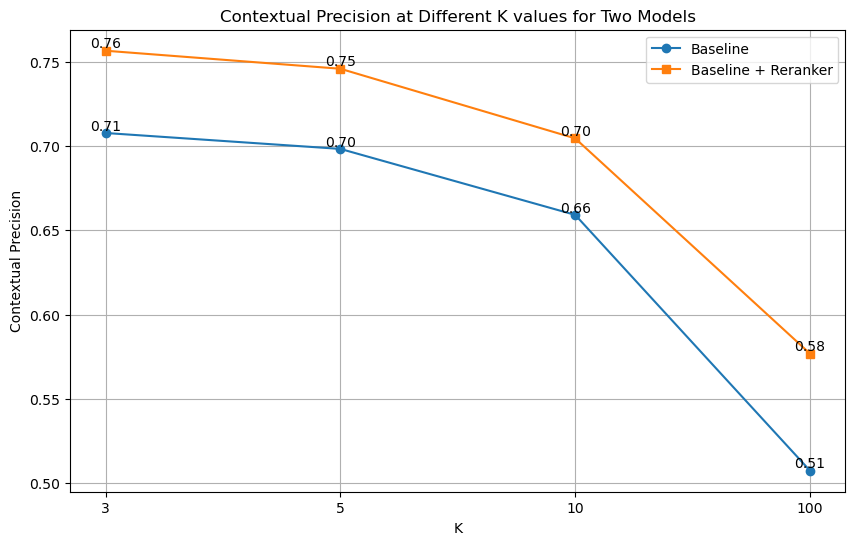

In [93]:
# Sample precision values for two models at k = 3, 5, 10, 100
k_values = [3, 5, 10, 100]
precision_model_1 = fin_results1['precision'].to_list()  # Model 1 precision values
precision_model_2 = fin_results2['precision'].to_list()  # Model 2 precision values
recall_model_1 = fin_results1['recall'].to_list()
recall_model_2 = fin_results2['recall'].to_list()
relevancy_model_1 = fin_results1['relevancy'].to_list()
relevancy_model_2 = fin_results2['relevancy'].to_list()

# Map k_values to uniformly spaced positions
uniform_k_positions = np.arange(len(k_values))  # [0, 1, 2, 3]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(uniform_k_positions, precision_model_1, marker='o', label='Baseline')
plt.plot(uniform_k_positions, precision_model_2, marker='s', label='Baseline + Reranker')

# Label each point on the lines
for i, pos in enumerate(uniform_k_positions):
    plt.text(pos, precision_model_1[i], f'{precision_model_1[i]:.2f}', ha='center', va='bottom')
    plt.text(pos, precision_model_2[i], f'{precision_model_2[i]:.2f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel("K")
plt.ylabel("Contextual Precision")
plt.title("Contextual Precision at Different K values for Two Models")
plt.legend()
plt.grid(True)

# Set custom x-ticks with k_values
plt.xticks(uniform_k_positions, k_values)  # Label the uniform positions with k_values

# Show plot
plt.show()

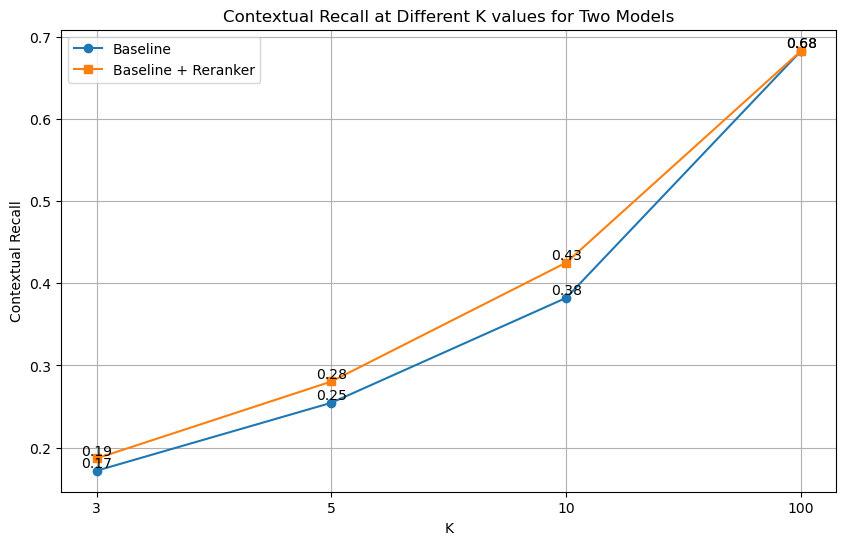

In [94]:
# Map k_values to uniformly spaced positions
uniform_k_positions = np.arange(len(k_values))  # [0, 1, 2, 3]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(uniform_k_positions, recall_model_1, marker='o', label='Baseline')
plt.plot(uniform_k_positions, recall_model_2, marker='s', label='Baseline + Reranker')

# Label each point on the lines
for i, pos in enumerate(uniform_k_positions):
    plt.text(pos, recall_model_1[i], f'{recall_model_1[i]:.2f}', ha='center', va='bottom')
    plt.text(pos, recall_model_2[i], f'{recall_model_2[i]:.2f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel("K")
plt.ylabel("Contextual Recall")
plt.title("Contextual Recall at Different K values for Two Models")
plt.legend()
plt.grid(True)

# Set custom x-ticks with k_values
plt.xticks(uniform_k_positions, k_values)  # Label the uniform positions with k_values

# Show plot
plt.show()

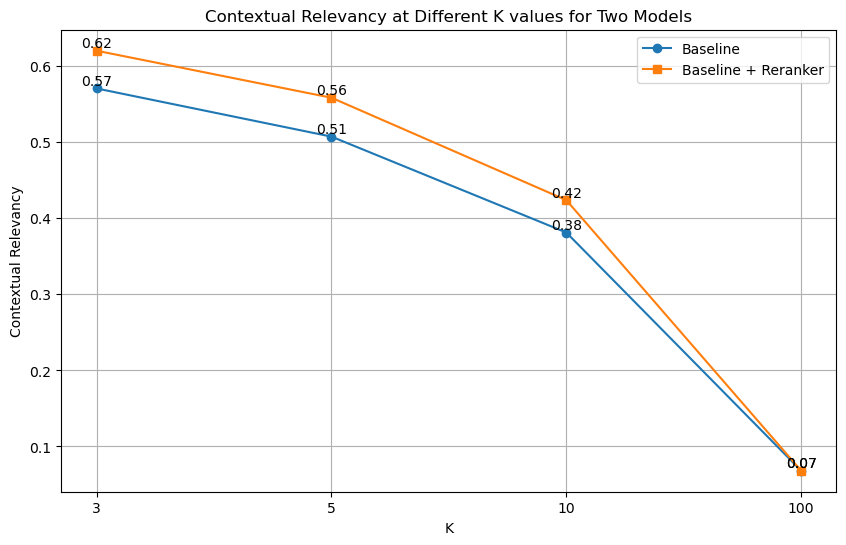

In [ ]:

# Map k_values to uniformly spaced positions
uniform_k_positions = np.arange(len(k_values))  # [0, 1, 2, 3]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(uniform_k_positions, relevancy_model_1, marker='o', label='Baseline')
plt.plot(uniform_k_positions, relevancy_model_2, marker='s', label='Baseline + Reranker')

# Label each point on the lines
for i, pos in enumerate(uniform_k_positions):
    plt.text(pos, relevancy_model_1[i], f'{relevancy_model_1[i]:.2f}', ha='center', va='bottom')
    plt.text(pos, relevancy_model_2[i], f'{relevancy_model_2[i]:.2f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel("K")
plt.ylabel("Contextual Relevancy")
plt.title("Contextual Relevancy at Different K values for Two Models")
plt.legend()
plt.grid(True)

# Set custom x-ticks with k_values
plt.xticks(uniform_k_positions, k_values)  # Label the uniform positions with k_values

# Show plot
plt.show()